In [1]:
import math
import urllib

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch

from interpol import grid_pull, grid_push, grid_count
from interpol.api import affine_grid


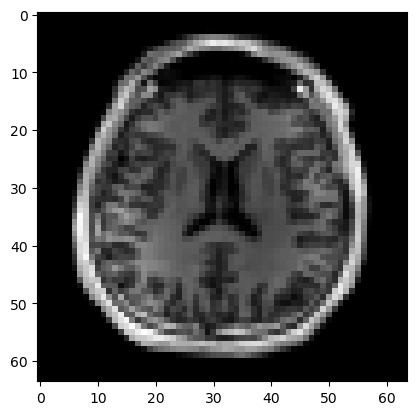

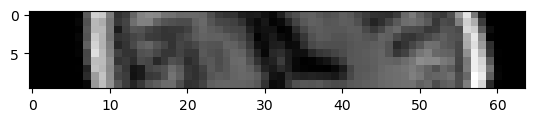

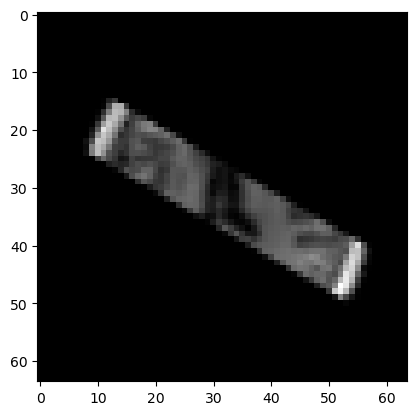

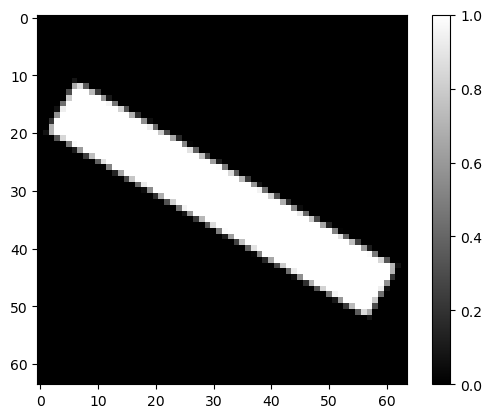

In [14]:

# we use image from internate
image_url = (
    "https://upload.wikimedia.org/wikipedia/commons/b/b2/MRI_of_Human_Brain.jpg"
)
img = PIL.Image.open(urllib.request.urlopen(image_url))
img = img.resize((64, 64))

# gray scale numpy array
img = np.array(img.convert("L"))
img = torch.tensor(img).float()

fig, ax = plt.subplots(1, 1)
ax.imshow(img.numpy(), cmap="gray")
fig.savefig("input_img.png")

# align center to the middle of the image
center = (img.shape[0] - 1) / 2
S_center = torch.tensor(
    [
        [1, 0, -center],
        [0, 1, -center],
        [0, 0, 1],
    ],
    dtype=torch.float32,
)

# we rotate the image by theta degree
theta = 30
theta = math.radians(theta)
S_rot = torch.tensor(
    [
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1],
    ],
    dtype=torch.float32,
)

# we slices a (thinkness, output_size) slice from
# the image along the center
thinkness = 10
output_size = 64

# from output image to centered image
S_center_output = torch.tensor(
    [
        [1, 0, -(thinkness - 1) / 2],
        [0, 1, -(output_size - 1) / 2],
        [0, 0, 1],
    ],
    dtype=torch.float32,
)

int_interpo = 1

# mapping from output image to input image
full_affine = (S_rot @ S_center).inverse() @ S_center_output

# build dense field of sampling coordinates
grid = affine_grid(full_affine, [thinkness, output_size])
output_img = grid_pull(img, grid, bound="mirror", interpolation=int_interpo)

fig, ax = plt.subplots(1, 1)
ax.imshow(output_img, cmap="gray")
fig.savefig("/tmp/output_img.png")

# we put the transformed image back to the original space
full_affine_inv = full_affine.inverse()
igrid = affine_grid(full_affine_inv, img.shape)
output_img_splat = grid_pull(
    output_img, igrid, bound="zero", interpolation=int_interpo,
    extrapolate=True,
)

fig, ax = plt.subplots(1, 1)
ax.imshow(output_img_splat, cmap="gray")
fig.savefig("/tmp/output_img_splat.png")

# we also look at the occupancy
output_img_ones_splat = grid_pull(
    torch.ones_like(output_img), igrid, bound="zero", interpolation=int_interpo,
    extrapolate=True,
)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(output_img_ones_splat, cmap="gray")
fig.colorbar(im, ax=ax)
fig.savefig("/tmp/output_img_ones_splat.png")

# splat with grid_push
output_img_push = grid_push(
    output_img, grid, img.shape, bound="mirror", interpolation=int_interpo,
)
output_img_count = grid_count(
    output_img, grid, img.shape, bound="mirror", interpolation=int_interpo,
)

fig, ax = plt.subplots(1, 3)
im = ax[0].imshow(output_img_push, cmap="gray")
im = ax[1].imshow(output_img_count, cmap="gray")
im = ax[2].imshow(output_img_push / output_img_count.clamp_min(1e-8), cmap="gray")
fig.colorbar(im, ax=ax[1])
fig.savefig("/tmp/output_img_ones_push.png")
